* http://www.ethanrosenthal.com/2018/01/28/time-series-for-scikit-learn-people-part1/

In general, a learning problem considers a set of n samples of data and then tries to predict properties of unknown data.
If each sample is more than a single number and, for instance, a multi-dimensional entry (aka multivariate data), it is
said to have several attributes or features.

Training set and testing set
Machine learning is about learning some properties of a data set and then testing those properties against another
data set. A common practice in machine learning is to evaluate an algorithm by splitting a data set into two. We
call one of those sets the training set, on which we learn some properties; we call the other set the testing set, on
which we test the learned properties.

In the case of the digits dataset, the task is to predict, given an image, which digit it represents. We are given samples
of each of the 10 possible classes (the digits zero through nine) on which we fit an estimator to be able to predict the
classes to which unseen samples belong.

Data Representation in Scikit-Learn
Machine learning is about creating models from data: for that reason, we’ll start by discussing how data can be represented in order to be understood by the computer. The best way to think about data within Scikit-Learn is in terms of tables of data.

Data as table
A basic table is a two-dimensional grid of data, in which the rows represent individual elements of the dataset, and the columns represent quantities related to each of these elements.

Here each row of the data refers to a single observed flower, and the number of rows is the total number of flowers in the dataset. In general, we will refer to the rows of the matrix as samples, and the number of rows as n_samples.

Likewise, each column of the data refers to a particular quantitative piece of information that describes each sample. In general, we will refer to the columns of the matrix as features, and the number of columns as n_features.

Features matrix
This table layout makes clear that the information can be thought of as a two-dimensional numerical array or matrix, which we will call the features matrix. By convention, this features matrix is often stored in a variable named X. The features matrix is assumed to be two-dimensional, with shape [n_samples, n_features], and is most often contained in a NumPy array or a Pandas DataFrame, though some Scikit-Learn models also accept SciPy sparse matrices.

The samples (i.e., rows) always refer to the individual objects described by the dataset. For example, the sample might be a flower, a person, a document, an image, a sound file, a video, an astronomical object, or anything else you can describe with a set of quantitative measurements.

The features (i.e., columns) always refer to the distinct observations that describe each sample in a quantitative manner. Features are generally real-valued, but may be Boolean or discrete-valued in some cases.

Target array
In addition to the feature matrix X, we also generally work with a label or target array, which by convention we will usually call y. The target array is usually one dimensional, with length n_samples, and is generally contained in a NumPy array or Pandas Series. The target array may have continuous numerical values, or discrete classes/labels. While some Scikit-Learn estimators do handle multiple target values in the form of a two-dimensional, [n_samples, n_targets] target array, we will primarily be working with the common case of a one-dimensional target array.

Often one point of confusion is how the target array differs from the other features columns. The distinguishing feature of the target array is that it is usually the quantity we want to predict from the data: in statistical terms, it is the dependent variable. For example, in the preceding data we may wish to construct a model that can predict the species of flower based on the other measurements; in this case, the species column would be considered the feature.


In [27]:
! pip install skits

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns # advanced vizs
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
from matplotlib.pyplot import figure
from matplotlib.pyplot import suptitle
import matplotlib.style as style
from IPython.display import display, HTML
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
warnings.filterwarnings('ignore') 
pd.set_option('display.width',1000, 'display.max_rows',200, 'display.max_columns',900,'max_colwidth',1000)
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [16]:
# create time series dataframe except a region
def create_dataframe(file, region):
    df = pd.read_csv(file)
    df1 = df[df['Country/Region'] != region]
    df1.drop(['Province/State', 'Country/Region','Lat', 'Long'], axis = 1, inplace = True)
    df2 = df1.sum()  
    return df2

In [17]:
confirmed = create_dataframe("../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv","Mainland China")
death = create_dataframe("../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv","Mainland China")
recovered = create_dataframe("../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv","Mainland China")

In [18]:
y = confirmed.to_frame().reset_index()
y.columns =['index','count']

In [19]:
y['index'] = pd.to_datetime(y['index'])

In [20]:
y.set_index("index", inplace=True)

Excellent, we have our time series. What now? Let’s think about what we actually want to do with it. To keep things simple, let’s say that we want to be able to predict the next value in the time series. As an example, if it was noon (i.e. 12:00 PM) on May 2nd, we would be trying to predict the number of bikes available at 12:05 PM, since our time series is in periods of 5 minutes. Visually, this looks like the following:

In [21]:
y.head()

,count
index,
2020-01-22,8.0
2020-01-23,14.0
2020-01-24,25.0
2020-01-25,35.0
2020-01-26,56.0


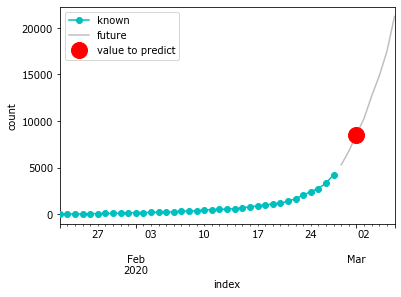

In [22]:
known = y.loc['2020-01-22':'2020-02-27']
unknown = y.loc['2020-02-28':'2020-03-06']
to_predict = y.loc['2020-03-01':'2020-03-01']

fig, ax = plt.subplots();
known.plot(ax=ax, c='c', marker='o', zorder=3);
unknown.plot(ax=ax, c='grey', alpha=0.5);
to_predict.plot(ax=ax, c='r', marker='o', markersize=16,
                linestyle='');

ax.legend(['known', 'future', 'value to predict']);
ax.set_ylabel('count');

Now that we have framed our problem in terms of what we know and what we want to predict, we walk back from whence we came towards ol’ machine learning. In time series, instead of creating a bunch of features to input into our model, we instead use the historical, known values of our time series as “features” to input into a model. The future value of the time series that we want to predict is then our target label. Mathematically, we will think of \textbf{X}X as our “feature matrix” or “design matrix” from machine learning. We would like to approximate yy with \hat{y} 
y
^
​	
 , and we’ll learn a function \hat{y} = f(\textbf{X}) 
y
^
​	
 =f(X) in order to do this. Our \textbf{X}X matrix consists of previous values of yy, our time series. Thus, at some point in time tt,

\mathbf{X}_{t} = \mathbf{y}_{t^{\prime}\lt t}
X 
t
​	
 =y 
t 
′
 <t
​	
 
where I have somewhat abused notation via the following

\mathbf{y}_{t^{\prime}\lt t} \equiv \big(y_{1}, y_{2}, \ldots, y_{t-2}, y_{t-1} \big)
y 
t 
′
 <t
​	
 ≡(y 
1
​	
 ,y 
2
​	
 ,…,y 
t−2
​	
 ,y 
t−1
​	
 )
where the portion on the right denotes a vector. Consequently, if we want to predict yy at time tt, then it will be

\hat{y}_{t} = f(\mathbf{X}_{t})
y
^
​	
  
t
​	
 =f(X 
t
​	
 )
\hat{y}_{t} = f(\mathbf{y}_{t^{\prime}\lt t-1})
y
^
​	
  
t
​	
 =f(y 
t 
′
 <t−1
​	
 )
Note that we cannot use future values to also predict the future. This is why we have to use the t-1t−1 value of \textbf{X}X to predict y_{t}y 
t
​	
 . In our graph from above, tt is 12:05 PM, the time that we are trying to predict. \textbf{X}_{t-1}X 
t−1
​	
  is the “known” cyan curve, and y_{t}y 
t
​	
  is the “value to predict” red marker.

Building the X matrix
Now that we’re able to think of time series in the comfortable form of \hat{y} = f(\mathbf{X}) 
y
^
​	
 =f(X), how do we build up the full design matrix \textbf{X}X? We would like to think of things in the scikit-learn paradigm, where we want to fit a design matrix \textbf{X}X in which each column is a feature dimension and each row is a separate “sample” or “data point”. In our case, each column of \textbf{X}X will map to a previous value of yy. We then have to think of how to build multiple samples.

Before we build samples, though, let’s introduce the concept of a window. Recall that \mathbf{X}_{t} = \mathbf{y}_{t^{\prime}\lt t}X 
t
​	
 =y 
t 
′
 <t
​	
 . We could use all values of yy up until time tt, but this would quickly get unwieldy for large time series. Instead, we can consider some finite number of yy values preceding tt. This finite range is our window. For a window size ww, \mathbf{X}_{t} = \big(y_{t-w}, y_{t-w+1},\ldots, y_{t-2}, y_{t-1} \big)X 
t
​	
 =(y 
t−w
​	
 ,y 
t−w+1
​	
 ,…,y 
t−2
​	
 ,y 
t−1
​	
 ).

We can now build up our data samples. We will chop our time series into a bunch of samples where each \mathbf{X}_{t}X 
t
​	
  is a length ww vector, and our targets are y_{t}y 
t
​	
 . We’ll again do this graphically. We take a window size of 5, and create 8 data points near noon on May 2nd. Each line plotted corresponds to a different row in our \mathbf{X}X matrix, and the lines are vertically offset for clarity.

In [25]:
np.where(y.index == '2020-02-20')[0][0]

29

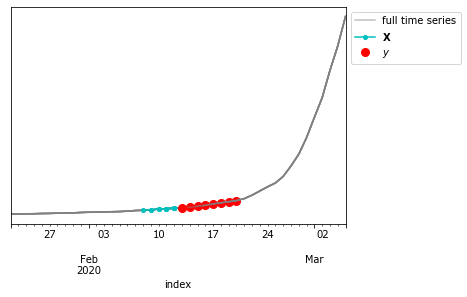

In [23]:
fig, ax = plt.subplots();

start = np.where(y.index == '2020-01-22')[0][0]
middle = np.where(y.index == '2020-02-20')[0][0]
end = np.where(y.index == '2020-03-06')[0][0]

window = 5

for i in range(8):

    full = y.iloc[start:end]
    train = y.iloc[middle - i - window:middle - i ]
    predict = y.iloc[middle - i:middle - i + 1]

    (full + 2*i).plot(ax=ax, c='grey', alpha=0.5);
    (train + 2*i).plot(ax=ax, c='c', markersize=4,
                       marker='o')
    (predict + 2*i).plot(ax=ax, c='r', markersize=8,
                         marker='o', linestyle='')


ax.get_yaxis().set_ticks([]);
ax.legend(['full time series',
           '$\mathbf{X}$',
           '$y$'],
          bbox_to_anchor=(1, 1));

In [26]:
y.iloc[29 - 5 - 5:29 - 5 ]

,count
index,
2020-02-10,457.0
2020-02-11,476.0
2020-02-12,523.0
2020-02-13,538.0
2020-02-14,595.0
